In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

In [3]:
data_path = 'D:/tianchi/diabate/'

train = pd.read_csv(data_path+'train_divide.csv',encoding='gb2312')
Y_train = train['血糖']
train  = train.drop(['血糖'],axis=1)
test = pd.read_csv(data_path+'test_divide.csv',encoding='gb2312')

In [5]:
param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'l2',
        'num_leaves': 12,
        #'min_data_in_leaf': 5,
        #'min_sum_hessian_in_leaf': 1e-3,
        'learning_rate': 0.01,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 10,
        'reg_alpha': 0,
        #'reg_lambda': 100,
        'verbose': 0,
        #'max_bin': 300,

    }

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train.values, Y_train.values, test_size=0.2, random_state=100)
lgb_train = lgb.Dataset(x_train, y_train)

print ('cv to find best num_boost_round')
bst = lgb.cv(
    param, lgb_train, num_boost_round=10000, nfold=10, stratified=False, shuffle=True,
    early_stopping_rounds=100, verbose_eval=100, show_stdv=True, seed=100)

print (u'迭代:', len(bst['l2-mean']), u' CV:', bst['l2-mean'][-1])

cv to find best num_boost_round
[100]	cv_agg's l2: 1.36988 + 0.156594
[200]	cv_agg's l2: 1.29338 + 0.135166
[300]	cv_agg's l2: 1.25732 + 0.126477
[400]	cv_agg's l2: 1.2482 + 0.121178
[500]	cv_agg's l2: 1.24661 + 0.117757
迭代: 458  CV: 1.24596254313


Plot feature importances...


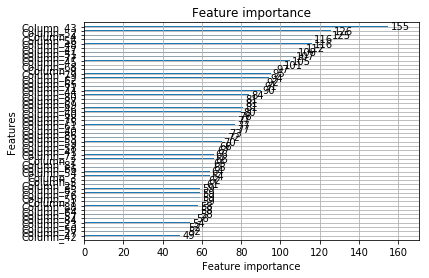

In [7]:
gbm = lgb.train(params=param,
                train_set=lgb_train,
                num_boost_round=len(bst['l2-mean']),
                )

print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=50)
plt.show()


In [8]:
print ('Start predicting...')

y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
y_pred2 = np.round(y_pred, 2)


result = pd.DataFrame(
    {'result': list(y_pred), 'result2': list(y_pred2), 'raw': y_test})
#result[['result','result2','raw']].to_csv('./blood_glucosebase2.csv', index=None,header=False)
# 用scikit-learn计算MSE
print('线下得分：    {}'.format(mean_squared_error(y_test,y_pred)*0.5))

Start predicting...
线下得分：    0.49174742213915723


In [9]:
print ('Start predicting...')
y_pred = gbm.predict(test, num_iteration=gbm.best_iteration)
y_pred2 = np.round(y_pred, 2)
np.savetxt("./divide_predict_top50withoriginal.csv", y_pred, delimiter=",")

Start predicting...
